**Group Members:** Jojo Hu (47939335), Lanson Lin (54504196), Bella Wang (33822388)

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

## Background Information
A UBC Computer Science research group, led by Frank Wood, is studying how people play Minecraft by collecting player activity data from a specific server. To run the project effectively, they need to recruit the right players and manage various software and hardware resources. They want to know "kinds" of players are most likely to contribute a large amount of data so that they can target those players in their recruiting efforts.

## Research Question
We want to know: can we predict total playtime based on player experience and newsletter subscription status? We will investigate this research question using KNN regression on the `players.csv` dataset

## Dataset
First, we load the data, taking care to convert the `experience` and `gender` columns to factors using `mutate`. Then, we reorder the `experience` column to have it be ordered by skill level instead of alphabetically. Finally, we use `table` to show the possible values of `gender` and `experience`.

In [2]:
# Load the CSV from the Github URL and convert `experience` and `gender` to factors
players <- read_csv("https://raw.githubusercontent.com/Yh194/ubc-dsci100-21/refs/heads/main/data/players.csv") |>
    mutate(across(c(experience, gender), as.factor))

# Order experience levels correctly
players$experience <- factor(players$experience, levels = c('Beginner', 'Amateur', 'Regular', 'Pro', 'Veteran'))

# Show possible values for factors and their distribution
table(players$gender)
table(players$experience)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



          Agender            Female              Male        Non-binary 
                2                37               124                15 
            Other Prefer not to say      Two-Spirited 
                1                11                 6 


Beginner  Amateur  Regular      Pro  Veteran 
      35       63       36       14       48 

From the above code, we can determine the following: the `players.csv` file is a comma-separated CSV file with 7 columns and 196 rows.

### Specification

| Column Name      | Data Type | Meaning                                                   | Possible values/constraints                        |
|------------------|-----------|-----------------------------------------------------------|----------------------------------------------------|
| **experience**   | `fct`     | How much experience the player has in the game            | 'Beginner', 'Amateur', 'Regular', 'Pro', 'Veteran' |
| **subscribe**    | `lgl`     | Whether or not the player is subscribed to the newsletter |                                                    |
| **hashedEmail**  | `chr`     | The hash of the player's email, serving as a unique ID    |                                                    |
| **played_hours** | `dbl`     | The number of hours the player has played for             | Non-negative                                       |
| **name**         | `chr`     | The player's name                                         |                                                    |
| **gender**       | `fct`     | The player's gender                                       | 'Male', 'Female', 'Non-binary', 'Prefer not to say', 'Agender', 'Two-Spirited', 'Other' |
| **Age**          | `dbl`     | The player's age                                          | Non-negative                                       |

### Irrelevant Variables
`name` and `hashedEmail` are unique for each player, so they are not useful in our analysis.

### Potential Issues
- Played hours may be inaccurate because players might stay idle/AFK within the game, which would lead to an artificially inflated playtime
- Some players have disproportionately high playtime compared to others, which could skew averages
- Players could lie about or omit information such as age, gender, etc.
- There are a lot more male players (124) compared to other genders, which could introduce bias
- There are `NA` values present in the age column
- Skill level/experience is a very subjective column
  - Different people may have different opinions about what level of skill constitutes a "Pro" for example
  - The ranking is ambiguous, you can guess which value is more skilled than another but it's not clearly defined

# Methods and Results

## Summary Statistics
The data is already cleaned and wrangled, so we can move on to creating summary statistics. First, we find the minimum, mean, maximum, and standard deviation of the playtime observations for each experience level and for each subscription status (subscribed and not subscribed). To do this, we use `group_by` on the categorical variables and use `summarize` to compute the statistics.

In [3]:
experience_min_mean_max <- players |>
    group_by(experience) |>
    summarize(
        min = min(played_hours),
        mean = mean(played_hours),
        max = max(played_hours),
        sd = sd(played_hours),
    )
subscribe_min_mean_max <- players |>
    group_by(subscribe) |>
    summarize(
        min = min(played_hours),
        mean = mean(played_hours),
        max = max(played_hours),
        sd = sd(played_hours),
    )
experience_min_mean_max
subscribe_min_mean_max

experience,min,mean,max,sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Beginner,0,1.2485714,23.7,4.105547
Amateur,0,6.0174603,150.0,21.987214
Regular,0,18.2083333,223.1,57.957346
Pro,0,2.6000000,30.3,7.988838
Veteran,0,0.6479167,12.5,1.937424


subscribe,min,mean,max,sd
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,0,0.5019231,7.1,1.188258
TRUE,0,7.7756944,223.1,32.892470


Next, we summarize the proportion of each experience level (in counts and percentages), again using `group_by` and `summarize`.

In [4]:
experience_props <- players |>
    group_by(experience) |>
    summarize(count = n()) |>
    mutate(percentage = 100 * count / sum(count))
subscribe_props <- players |>
    group_by(subscribe) |>
    summarize(count = n()) |>
    mutate(percentage = 100 * count / sum(count))
experience_props
subscribe_props

experience,count,percentage
<fct>,<int>,<dbl>
Beginner,35,17.857143
Amateur,63,32.142857
Regular,36,18.367347
Pro,14,7.142857
Veteran,48,24.489796


subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


## Visualizations
We create a bar chart visualization that clearly shows a significant relationship between experience level and average play time for that experience level using `ggplot`:

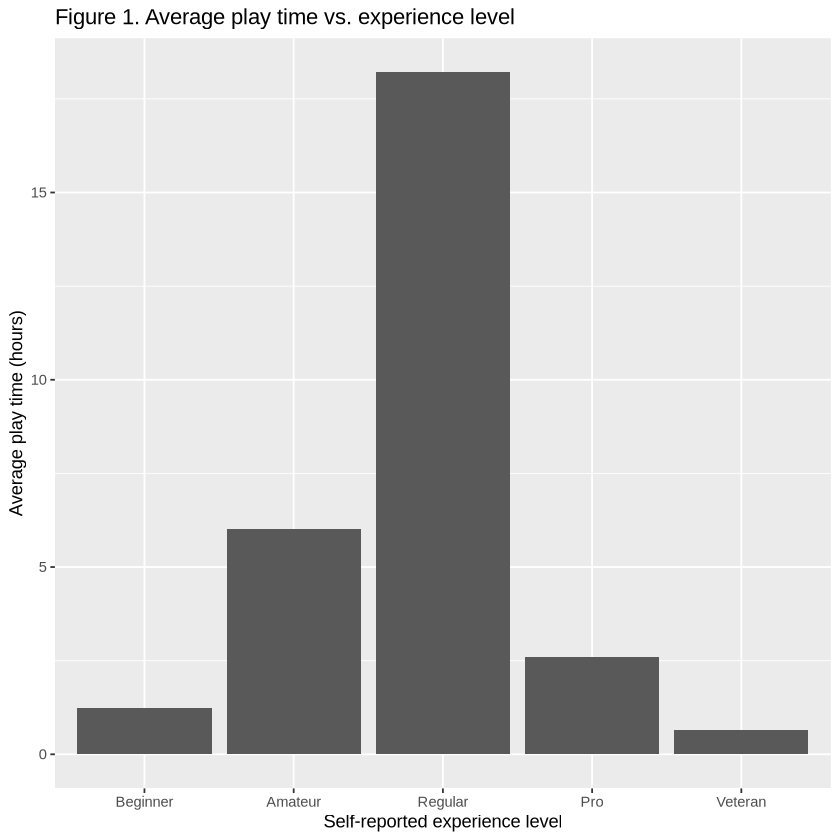

In [5]:
ggplot(experience_min_mean_max, aes(x = experience, y = mean)) +
    geom_bar(stat = "identity") +
    xlab("Self-reported experience level") +
    ylab("Average play time (hours)") +
    ggtitle("Figure 1. Average play time vs. experience level")

Next, we create a bar chart visualization which clearly shows a significant relationship between subscription status and average playtime.

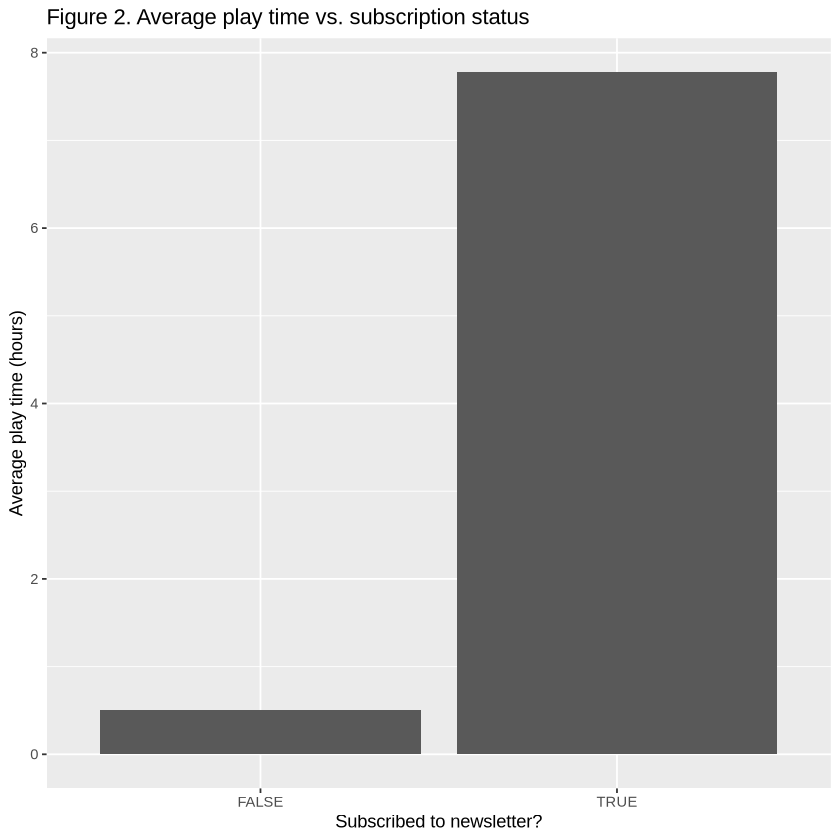

In [6]:
ggplot(subscribe_min_mean_max, aes(x = subscribe, y = mean)) +
    geom_bar(stat = "identity") +
    labs(x = "Subscribed to newsletter?", y = "Average play time (hours)") +
    ggtitle("Figure 2. Average play time vs. subscription status")

These two bar charts indicate that there should be a significant correlation between the predictors (`experience` and `subscribe`) and the response variable (`played_hours`). Because of this, we expect that the former two variables should be good predictors in a regression model. To further analyze this, we will create and tune a KNN regression model. We do not use linear regression because of the nonlinear correlation between `experience` and `played_hours`: the middle experience levels have a much higher average playtime, whereas the extremes have lower playtimes. This could be because people who are completely new to the game do not know what to do, driving them away from the game, and people who are experts in the game do not derive as much enjoyment from the game due to how much they have already played it in the past.

## Data Analysis
To begin, we first split the data into training and testing sets with a 80/20 train/test split. We use `played_hours` as the strata. We set the seed to the value `1234` to ensure reproducibility.

In [7]:
set.seed(1234)

players_split <- initial_split(players, prop = 0.8, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

Then, we make a recipe for our regression task. We use `step_bin2factor` to convert `subscribe` into a factor. Then, the `subscribe` and `experience` columns are converted into distinct numerical dummy columns for each possible state using `step_dummy`. Finally, we center and scale these numerical columns using `step_normalize`. We then bake the recipe on our testing data to get a feel for what the structure of the processed data looks like.

In [8]:
experience_recipe <- recipe(played_hours ~ experience + subscribe, players_train) |>
    step_bin2factor(subscribe) |>
    step_dummy(all_predictors()) |>
    step_normalize(all_predictors())
experience_recipe |> prep() |> bake(players_test) |> head()

played_hours,experience_Amateur,experience_Regular,experience_Pro,experience_Veteran,subscribe_no
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.3,-0.6946947,-0.5063697,3.8087282,-0.5163069,-0.5754968
0.0,-0.6946947,-0.5063697,-0.2608718,-0.5163069,-0.5754968
0.0,-0.6946947,-0.5063697,-0.2608718,-0.5163069,-0.5754968
0.0,-0.6946947,-0.5063697,-0.2608718,1.9244168,1.7264904
0.1,-0.6946947,-0.5063697,-0.2608718,1.9244168,-0.5754968
0.4,-0.6946947,-0.5063697,-0.2608718,1.9244168,-0.5754968


Before doing any analysis, we will first do cross-validation with 5 folds and tuning for each $K$ between 1 and 20. We ensure the seed is set to `1234` to ensure reproducibility. Then, we create a model specification with a tunable $K$. Then, we perform the cross-validation and tuning to find the RMSE for each $K$.

In [9]:
set.seed(1234)

spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
players_grid <- tibble(neighbors = seq(1, 20))
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

tuned_rmse <- workflow() |>
    add_model(spec_tune) |>
    add_recipe(experience_recipe) |>
    tune_grid(resamples = players_vfold, grid = players_grid) |>
    collect_metrics() |>
    filter(.metric == "rmse")
head(tuned_rmse)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,25.71071,5,9.338778,Preprocessor1_Model01
2,rmse,standard,25.71099,5,9.341294,Preprocessor1_Model02
3,rmse,standard,25.71245,5,9.342226,Preprocessor1_Model03
4,rmse,standard,25.71243,5,9.340948,Preprocessor1_Model04
5,rmse,standard,25.71515,5,9.338247,Preprocessor1_Model05
6,rmse,standard,25.71366,5,9.339666,Preprocessor1_Model06


We found the value of $K$ with the lowest RMSE and created a visualization to observe the RMSE for other values of $K$. As we can see, the most optimal value of $K$ (highlighted on the graph) is $K = 14$.

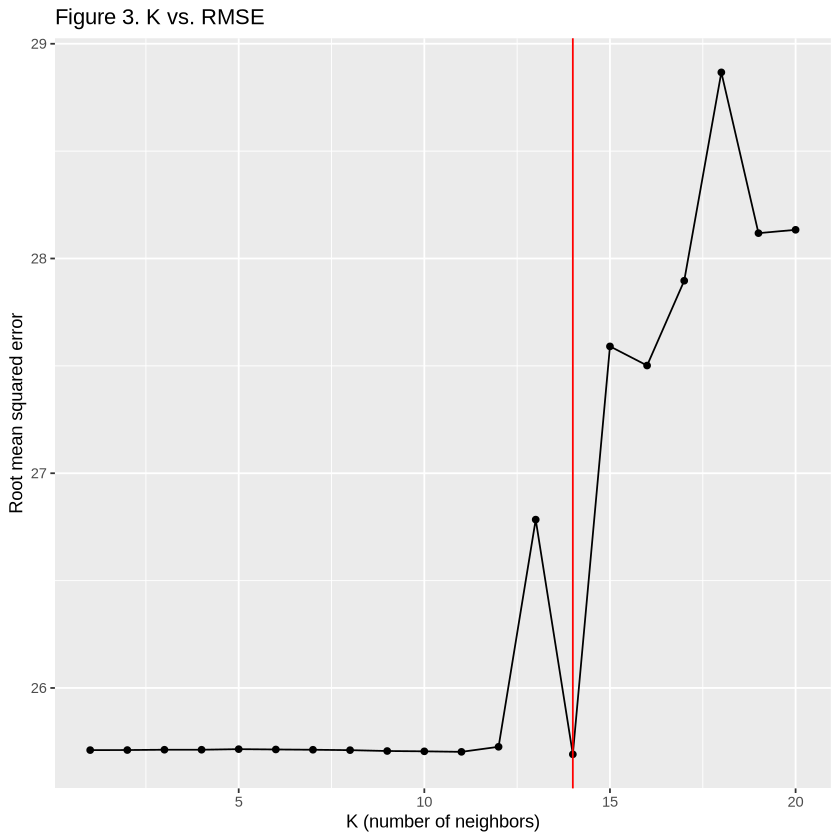

In [10]:
optimal_k <- tuned_rmse |>
    slice_min(mean, n = 1) |>
    pull(neighbors)

ggplot(tuned_rmse, aes(x = neighbors, y = mean)) +
    geom_point() + geom_line() +
    geom_vline(xintercept = optimal_k, color = "red") +
    xlab("K (number of neighbors)") +
    ylab("Root mean squared error") +
    ggtitle("Figure 3. K vs. RMSE")

Now that we know the best value of $K$ for our regression task, we can create a new model specification and create a new workflow that is fitted on the testing data.

In [11]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_model(players_spec) |>
    add_recipe(experience_recipe) |>
    fit(players_train)

After creating our workflow with optimal $K$, we can run the prediction on the testing set using `predict` and `bind_cols`, and then gather the metrics using `metrics`.

In [12]:
players_test_preds <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_test_summary <- players_test_preds |>
    metrics(truth = played_hours, estimate = .pred)
players_test_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10.226770529
rsq,standard,0.004259598
mae,standard,3.010535714


In this analysis, we cannot provide a visualization of the final result because of the nature of the data we're analyzing. As a result of using the `step_dummy` function to create dummy variables for the factors, our model technically has five predictors, which makes it impractical to represent their relationships in a 2D scatterplot. Visualizing the original factors is also not feasible since they are categorical variables and will only be displayed as a few discrete points on the graph. However, because the RMSPE is relatively low, we know that the predictors we chose are suitable for predicting the total playtime.

# Discussion

Through our preliminary visualizations, we found that regulars have the longest playtime amongst beginners, amateurs, regulars, pros, and veterans. These visualizations also showed that those who are subscribed to the newsletter have a longer average playtime than those who aren't. Because of these visualizations, we expected that there would be a strong relationship between playtime, experience, and subscription status, and thus, we expected that the latter two would be good predictors for the former. We created a KNN regression model which predicts played hours based on experience and subscription status. This model had relatively low RMSPE, which further solidifies the relationship between the response variable and the predictors, matching what we expected.

With this prediction system, experience and subscription status become suitable variables to predict a player's total playtime, since the RMSPE of the model is quite low. This makes it useful for future player recruitment for the project. The model can help forecast a player's dedication and engagement with the game, which can help with resource allocation.

Future research could explore whether subscription status directly causes increased playtime or if it's merely correlated. Adding more predictors, such as age, preferred game modes, or play frequency based on session data, might improve the model's accuracy and usefulness. Another question worth investiating is whether playtime trends differ across player segments, such as casual versus competitive gamers.


# References

Lee, T. T., Trevor Campbell, and Melissa. (n.d.). *Data science*. Retrieved April 5, 2025, from https://datasciencebook.ca/